## Spam Classification Using Word2vec Embeddings and LSTM Neural Network

A group of Google researchers developed [word2vec](https://www.tensorflow.org/tutorials/text/word2vec) in 2013, and it has become
the foundation of NLP that is also incorporated in BERT. Word2vec provides
an efficient method to represent words as vectors in a lower-dimensional
space. The word2vec will generate a vector consisting of
floating points for each word in a text corpus. 

The task is to transform the text words to vectors using a some neural network type. This neural network concise the of an output layer that has the same dimension as the input layer, with no activation function.  The kind of neural network like word2vec is called autoencoder.

We will use the word2vec embeddings model to prepare the data text to classification the task of the urls texts into two categories: urls that mean spam contents or no spam contents. Some of the best classifier text models are neural networks like recurrent NN of type LSTM (Long Short Term Memory). In the first step, we make data analysis, data clean, and features engineering. To the second step, we should be building the word2vec embeddings model to feed the LSTM classification model

In [2]:
# Importing the Libraries Requirel
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup 

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from colorama import Fore, Back, Style

import tensorflow as tf

from keras.layers import Dense, Flatten, Embedding, Input, LSTM
#from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

#gensim w2v
#word2vec
#from gensim.models import Word2Vec

from tensorflow import keras

from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading and reading data
df = pd.read_csv('unseen.csv')
# Show the 5 first rows
df.head(5)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
# Check data for null values
df.isnull().sum()

url        0
is_spam    0
dtype: int64

In [5]:
# Check  data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133473 entries, 0 to 133472
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   url      133473 non-null  object
 1   is_spam  133473 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.1+ MB


In [6]:
# Modifying the data type boolean of 'is_spam' to object
df['is_spam'] = df['is_spam'].astype(object)

In [64]:

#df = df.replace(['True', 'False'], ['spam','ham'], inplace=True)

False    90901
True     42572
Name: is_spam, dtype: int64

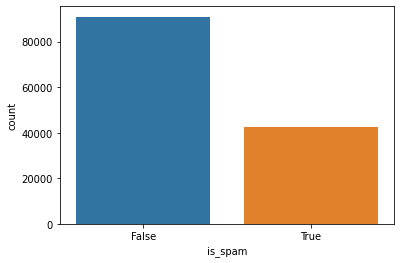

In [7]:
# Show the amount records of each classes
sns.countplot(x = df['is_spam']);
df['is_spam'].value_counts()

### Clean the Text data

In [8]:
# Creating the function to deal the main regular expressions in the text
def clean_carater(data):

    # Changing the e-mail address to 'email'.
    processed = data.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'email')

    # Changing URLs to 'webaddress' expression.
    processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

    # Changing money symbol  to 'money symbol'.
    processed = processed.str.replace(r'£|\$', 'moneysymbol')

    # Changing the number fone with 10 digits to 'numberfone' (Formats include parentheses, spaces, no spaces, indents)
    processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'numberfone')
    
    # Changing the number sequences to 'number'.
    processed = processed.str.replace(r'\d+(\.\d+)?', 'number')

    # Removing punctuation.
    processed = processed.str.replace(r'[^\w\d\s]', ' ')

    # Changing empty space between terms by unique space.
    processed = processed.str.replace(r'\s+', ' ')

    # Remova os espaços em branco à esquerda e à direita Removing the empty spaces left and spaces
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    return processed

In [9]:
# Applying the claen_caracter function on the texts
pro = clean_carater(data = df['url'])

# Converting all caracters upcase to lowcase.
processed = pro.str.lower()
print(processed)

0         https briefingday usnumber list manage com uns...
1                                       https www hvper com
2         https briefingday com m vnumbernnumberinumberf...
3              https briefingday com n number m commentform
4                                 https briefingday com fan
                                ...                        
133468    https www wsj com articles the philadelphia ea...
133469    https cdn substack com image fetch f_auto q_au...
133470    https docs google com forms d e numberfaipqlsf...
133471                          https bookclub substack com
133472                            https awards substack com
Name: url, Length: 133473, dtype: object


In [10]:
# Incert the cleaned text in original data
pre = pd.DataFrame(data = processed, columns=['url'])

dff = df.drop('url', axis = 1)
dff = pd.concat([dff, pre], axis = 1)

In [11]:
# Removing stopwords

stop = set(nltk.corpus.stopwords.words('english'))

punctuation = list(string.punctuation)
# Add pontuation to stopwords list
stop.update(punctuation)

def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Removing noise text
def clean_text(text):
    text = remove_stopwords(text)
    return text

dff['url'] = dff['url'].apply(clean_text)
dff['url']

0         https briefingday usnumber list manage com uns...
1                                       https www hvper com
2         https briefingday com vnumbernnumberinumberfnu...
3                https briefingday com n number commentform
4                                 https briefingday com fan
                                ...                        
133468    https www wsj com articles philadelphia eagles...
133469    https cdn substack com image fetch f_auto q_au...
133470    https docs google com forms e numberfaipqlsfdl...
133471                          https bookclub substack com
133472                            https awards substack com
Name: url, Length: 133473, dtype: object

## Features Engineering

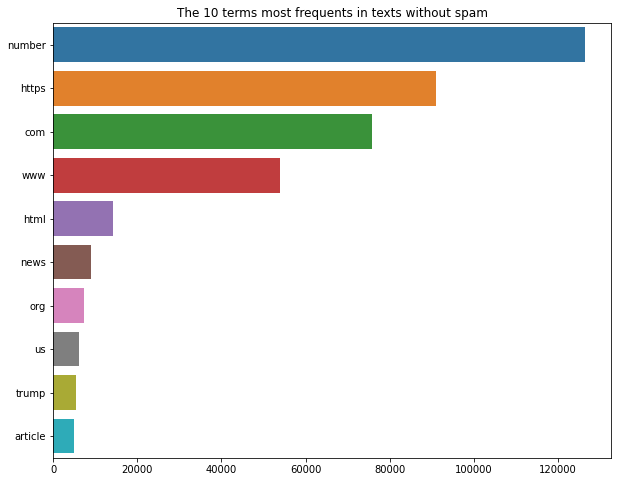

In [12]:
# Creating and show the terms most frequents in texts without spam 

corpus_spam_false = []

sms= dff[dff['is_spam'] ==  False]['url'].str.split()
sms = sms.values.tolist()
corpus_spam_false = [word for i in sms for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_spam_false:
    if word in stop:
        dic[word]+=1

import collections

counter= collections.Counter(corpus_spam_false)
most=counter.most_common()

x, y = [], []
for word,count in most[:10]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 8))        
plt.title("The 10 terms most frequents in texts without spam")
sns.barplot(x=y,y=x);

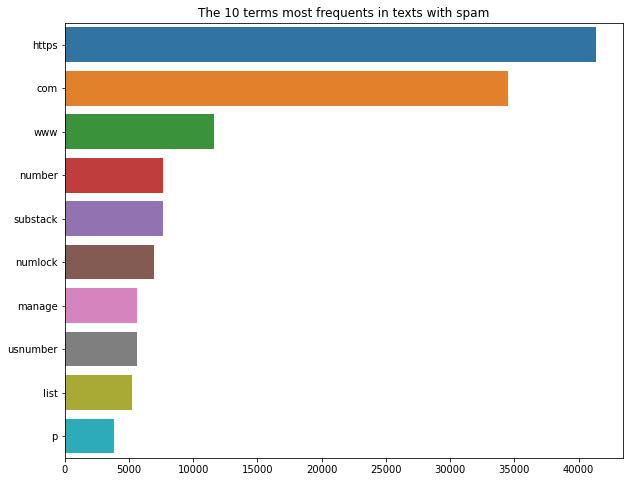

In [13]:
# Creating and show the terms most frequents in texts with spam 

corpus_spam_true = []

sms= dff[dff['is_spam'] ==  True]['url'].str.split()
sms = sms.values.tolist()
corpus_spam_true = [word for i in sms for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus_spam_true:
    if word in stop:
        dic[word]+=1

import collections

counter= collections.Counter(corpus_spam_true)
most=counter.most_common()

x, y = [], []
for word,count in most[:10]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(10, 8))        
plt.title("The 10 terms most frequents in texts with spam")
sns.barplot(x=y,y=x);

In [14]:
# Building the one function to calculate length of urls, excluding the spaces.
dff['url_comp'] = dff['url'].apply(lambda x: len(x) - x.count(" "))

# Função para calcular a fração da pontuação em termos do comprimento da mensagem.
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

dff['ponto%'] = dff['url'].apply(lambda x: count_punct(x))


In [15]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133473 entries, 0 to 133472
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   is_spam   133473 non-null  object 
 1   url       133473 non-null  object 
 2   url_comp  133473 non-null  int64  
 3   ponto%    133473 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ MB


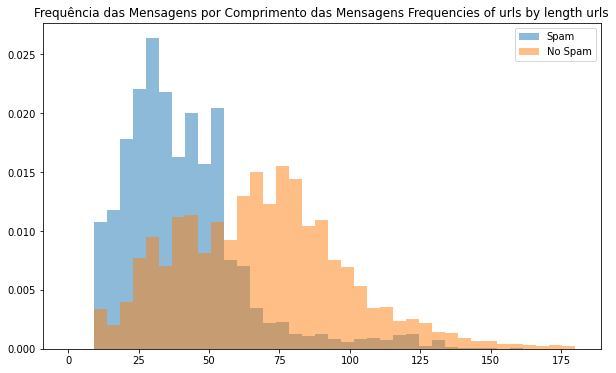

In [16]:
# Showing the distribution of url lengths to both classes

bins = np.linspace(0, 180, 40)

plt.figure(figsize = (10, 6))
plt.hist(dff[dff['is_spam']== True]['url_comp'], bins, alpha=0.5, density=True, label='Spam')
plt.hist(dff[dff['is_spam']== False]['url_comp'], bins, alpha=0.5, density=True, label='No Spam')
plt.legend(loc='upper right')
plt.title('Frequência das Mensagens por Comprimento das Mensagens Frequencies of urls by length urls')
plt.show()

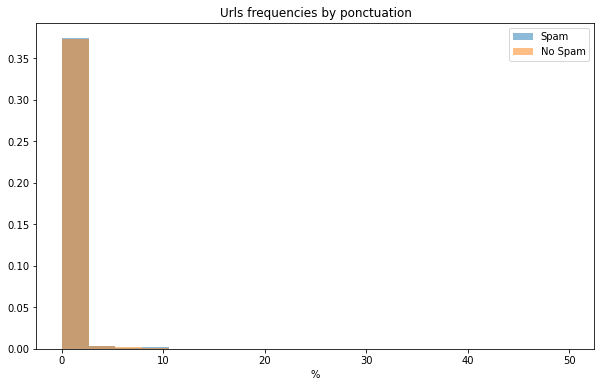

In [17]:
# Exibindo a distribuição da fração da pontuação das mensagens para as classes 'blocked' e 'ok'.

bins = np.linspace(0, 50, 20)

plt.figure(figsize = (10, 6))
plt.hist(dff[dff['is_spam']== True]['ponto%'], bins, alpha=0.5, density=True, label='Spam')
plt.hist(dff[dff['is_spam']== False]['ponto%'], bins, alpha=0.5, density=True, label='No Spam')
plt.title('Urls frequencies by ponctuation')
plt.xlabel('%')
plt.legend(loc='upper right')
plt.show()

## Creating Word2vec Word Embeddings in Gensim

#### Firstly, we need split the data into sentences which is requires by the constructor of the Word2Vec class in Gensim

In [18]:

# function to clean and pre-process the text.
def clean_reviews(review):  
    
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

In [19]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[]
sum=0
for review in dff['url']:
  sents=tokenizer.tokenize(review.strip())
  sum+=len(sents)
  for sent in sents:
    cleaned_sent = clean_reviews(sent)
    
    sentences.append(cleaned_sent.split()) # can use word_tokenize also.
print(sum)
print(len(sentences))  # total no of sentences

133473
133473


In [20]:
# We can to see the few sentences
for te in sentences[:5]:
  print(te,"\n")

['http', 'briefingday', 'usnumber', 'list', 'manage', 'com', 'unsubscribe'] 

['http', 'www', 'hvper', 'com'] 

['http', 'briefingday', 'com', 'vnumbernnumberinumberfnumber'] 

['http', 'briefingday', 'com', 'n', 'number', 'commentform'] 

['http', 'briefingday', 'com', 'fan'] 



In [21]:
import gensim

w2v_model=gensim.models.Word2Vec(sentences=sentences,window=10,min_count=1)

w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(9002919, 13405080)

##### Parameters: 

`sentences` : The sentences we have obtained.

`window` : The number f words around any word to see the context.

`min_count` : The minimum number of times a word should appear for its embedding to be formed or learnt.

In [22]:
# total numberof extracted words.
vocab=w2v_model.wv.key_to_index 
print("The total number of words are : ",len(vocab))

The total number of words are :  62345


In [23]:
# words most similar to a given word.
w2v_model.wv.most_similar('rain')

[('wind', 0.7875035405158997),
 ('landfall', 0.7806764841079712),
 ('storm', 0.7771666049957275),
 ('tropical', 0.7766754627227783),
 ('heavy', 0.7562013864517212),
 ('eta', 0.7500133514404297),
 ('gulf', 0.7340613603591919),
 ('hurricane', 0.730910062789917),
 ('pau', 0.7224106788635254),
 ('bay', 0.7193511128425598)]

In [24]:
# similaraity b/w two words
w2v_model.wv.similarity('woman','man')

0.55588305

##### We creating a dictionary with words in vocab and their embeddings. This will be used when we will be creating embedding matrix

In [25]:
# print(vocab)
vocab=list(vocab.keys())

In [26]:
# Creating the dictionary
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  62345


In [28]:
# Now since we will have to pad we need to find the maximum lenght of any document.
maxi=-1
for i,rev in enumerate(dff['url']):
  tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
print(maxi)

88


In [29]:
tok = Tokenizer()
tok.fit_on_texts(dff['url'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(dff['url'])

In [30]:

max_rev_len = 88  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim = 100 # embedding dimension as choosen in word2vec constructor

In [31]:
vocab_size

66558

In [32]:
#### We should encode the words in the urls using Keras tokenizer. 

from tensorflow.keras.preprocessing.sequence import pad_sequences

# now padding to have a amximum length of 88
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape  

(133473, 88)

In [33]:
# Now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector

In [35]:
# prepare train and val sets first 
Y= df['is_spam']
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=42)

## Create Baseline Model

In [36]:
# To create baseline model we using the Multinomial Naive Beays
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve, auc


def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs #[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.figure(figsize = (8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [37]:
# Enconding 
y_train.replace([True, False], [1,0], inplace=True)

y_test.replace([True, False], [1,0], inplace=True)

AUC: 0.7439
Accuracy: 68.94%


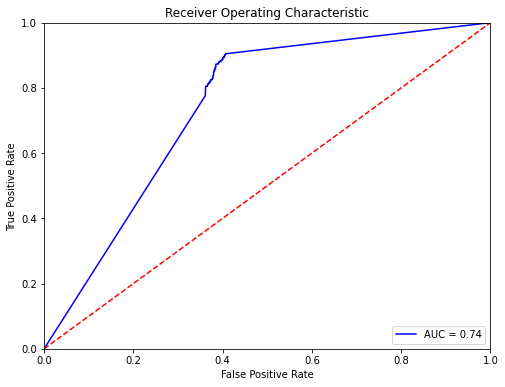

In [38]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(x_train, y_train)
probs = nb_model.predict_proba(x_test)[:, 1]

# Evaluate the classifier
evaluate_roc(probs, y_test)

In [ ]:
# Creating LSTM model
from tensorflow.keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
# model.add(CuDNNLSTM(64,return_sequences=False)) # loss stucks at about 
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

In [ ]:
# Showing the Trainable params of LSTM model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 78, 100)           6655800   
_________________________________________________________________
flatten (Flatten)            (None, 7800)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                124816    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,780,633
Trainable params: 6,780,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile the model
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# specify batch size and epocj=hs for training.
epochs= 20
batch_size=64

# fitting the model.
epochs = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split= 0.2)

Epoch 1/20
1335/1335 [==============================] - 87s 64ms/step - loss: 0.3221 - accuracy: 0.8617 - val_loss: 0.2153 - val_accuracy: 0.9098
Epoch 2/20
1335/1335 [==============================] - 82s 61ms/step - loss: 0.2283 - accuracy: 0.9039 - val_loss: 0.2104 - val_accuracy: 0.9181
Epoch 3/20
1335/1335 [==============================] - 82s 61ms/step - loss: 0.2040 - accuracy: 0.9122 - val_loss: 0.1853 - val_accuracy: 0.9278
Epoch 4/20
1335/1335 [==============================] - 82s 61ms/step - loss: 0.1886 - accuracy: 0.9176 - val_loss: 0.1899 - val_accuracy: 0.9291
Epoch 5/20
1335/1335 [==============================] - 83s 62ms/step - loss: 0.1807 - accuracy: 0.9197 - val_loss: 0.1760 - val_accuracy: 0.9351
Epoch 6/20
1335/1335 [==============================] - 82s 62ms/step - loss: 0.1695 - accuracy: 0.9241 - val_loss: 0.1799 - val_accuracy: 0.9269
Epoch 7/20
1335/1335 [==============================] - 83s 62ms/step - loss: 0.1663 - accuracy: 0.9226 - val_loss: 0.1744 -

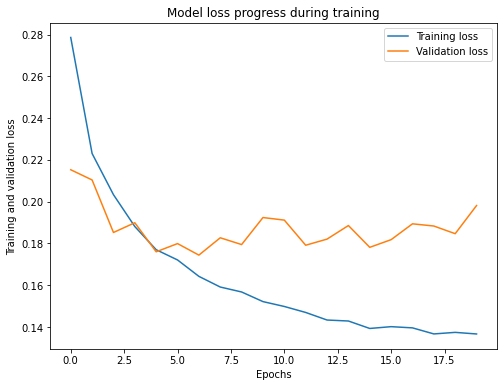

In [ ]:
# Plot the training loss and validation loss
plt.figure(figsize = (8, 6))
plt.plot(epochs.history['loss'])
plt.plot(epochs.history['val_loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Training loss', 'Validation loss']);

In [ ]:
# Getting predict values 
y_predict = model.predict_classes(x_test)

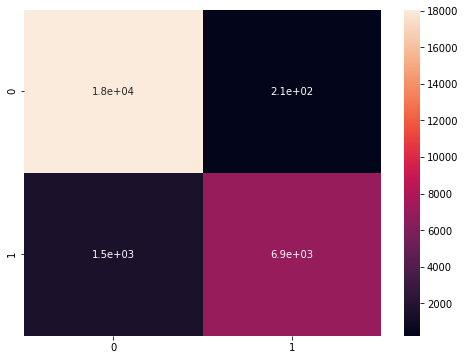

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True);

In [ ]:
# Report Classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96     18274
        True       0.97      0.82      0.89      8421

    accuracy                           0.94     26695
   macro avg       0.95      0.91      0.92     26695
weighted avg       0.94      0.94      0.93     26695



AUC: 0.9062
Accuracy: 93.65%


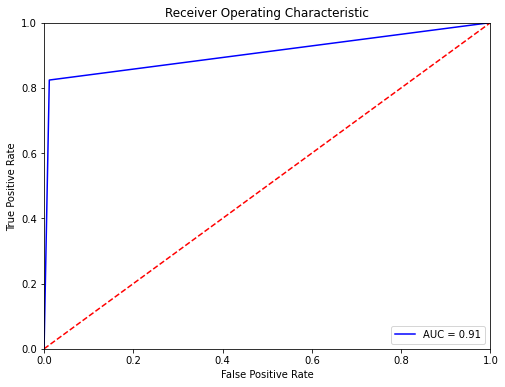

In [ ]:
# Plot the roc auc curve to embedding LSTM model
evaluate_roc(y_predict, y_test)

We easily see that peformance of embedding LSTM is much batter than the baseline model, we getting um AUC of the 0.9062 against 0.7439 from baseline model.